# Dependencies

In [ ]:
!git clone https://github.com/Nealcly/MuTual.git &> /dev/null
!git clone https://github.com/comprehensiveMap/MDFN.git &> /dev/null

In [ ]:
!pip install transformers &> /dev/null

In [ ]:
%cd /content/MDFN/

/content/MDFN


# Run training scripts

In [ ]:
!python run_MDFN.py \
--data_dir /content/MuTual/data/mutual \
--model_name_or_path \
google/electra-large-discriminator \
--model_type electra \
--task_name mutual \
--output_dir output_mutual_electra \
--cache_dir cached_models \
--max_seq_length 256 \
--do_train --do_eval \
--train_batch_size 6 \
--eval_batch_size 6 \
--learning_rate 4e-6 \
--num_train_epochs 3 \
--gradient_accumulation_steps 3 \
--local_rank -1 \
--seed 123456

# Dataset Inspection

In [ ]:
import json
import os
import collections
from tqdm import tqdm

In [ ]:
ANS = ["A", "B", "C", "D"]

In [ ]:
def load_data(path):
    examples = []
    for file in os.listdir(path):
        with open(os.path.join(path, file)) as f:
            x = json.load(f)
            examples.append(x)
    return examples

def load_pred(path):
    with open(path) as f:
        return json.load(f)

In [ ]:
train_examples = load_data("/content/MuTual/data/mutual_plus/train")
dev_examples = load_data("/content/MuTual/data/mutual_plus/dev")
test_examples = load_data("/content/MuTual/data/mutual_plus/test")

In [ ]:
train_examples = load_data("/content/MuTual/data/mutual/train")
dev_examples = load_data("/content/MuTual/data/mutual/dev")
# test_examples = load_data("/content/MuTual/data/mutual/test")

In [ ]:
options = list()
for x in train_examples + dev_examples + test_examples:
    options.extend(x['options'])

In [ ]:
cnt = collections.Counter(options)
safe = []
for k in sorted(list(cnt.keys()), reverse=True, key=cnt.get)[:100]:
    print(k, cnt[k])
    if cnt[k] > 100:
        safe.append(k)

In [ ]:
with open("/content/safe.txt", 'w') as f:
    for s in safe:
        f.write(s + "\n")

# Evaluation

In [ ]:
from run_MDFN import *

In [ ]:
seed = 123456
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


In [ ]:
config = ElectraConfig.from_pretrained("google/electra-large-discriminator",
                                        num_labels=4)
tokenizer = ElectraTokenizer.from_pretrained("google/electra-large-discriminator")
model = ElectraForMultipleChoicePlus(config=config)

model_path = "/content/drive/MyDrive/MUTUAL/modelplus-123456/mdfn.bin"

device = "cuda" if torch.cuda.is_available() else "cpu"
model.load_state_dict(torch.load(model_path))
model.to(device)
device

'cuda'

In [ ]:
def evaluate_mutual(model, model_type, device, data_dir, split="train"):
    model.eval()

    processor = MuTualProcessor()
    output_mode = "classification"
    label_list = processor.get_labels()

    if split == "train":
        examples = processor.get_train_examples(data_dir)
    elif split == "dev":
        examples = processor.get_dev_examples(data_dir)

    features = convert_examples_to_features(examples, label_list, 256, 20, tokenizer, output_mode)

    all_input_ids = torch.tensor(select_field(features, 'input_ids'), dtype=torch.long)
    all_input_mask = torch.tensor(select_field(features, 'input_mask'), dtype=torch.long)
    all_segment_ids = torch.tensor(select_field(features, 'segment_ids'), dtype=torch.long)
    all_sep_pos = torch.tensor(select_field(features, 'sep_pos'), dtype=torch.long)
    all_turn_ids = torch.tensor(select_field(features, 'turn_ids'), dtype = torch.long)
    if output_mode == "classification":
        all_label_ids = torch.tensor([f.label for f in features], dtype=torch.long)
    elif output_mode == "regression":
        all_label_ids = torch.tensor([f.label for f in features], dtype=torch.float)

    eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_sep_pos, all_turn_ids, all_label_ids)
    # Run prediction for full data

    eval_sampler = SequentialSampler(eval_data)
    eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=6, shuffle=False)

    eval_loss = 0.0
    nb_eval_steps = 0
    preds = None

    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        batch = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            inputs = {'input_ids': batch[0],
                    'attention_mask': batch[1],
                    'token_type_ids': batch[2] if model_type in ['bert', 'xlnet', 'albert'] else None, # XLM don't use segment_ids
                    'sep_pos': batch[3],
                    'turn_ids': batch[4],
                    'labels': batch[5]}
            #outputs = eval_model(**inputs)
            outputs = model(**inputs)
            tmp_eval_loss, logits = outputs[:2]

            eval_loss += tmp_eval_loss.detach().mean().item()
        
        nb_eval_steps += 1
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = inputs['labels'].detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)

    eval_loss = eval_loss / nb_eval_steps     
    result = compute_metrics("mutual", preds, out_label_ids)
    
    return examples, preds, out_label_ids, result

'cuda'

In [ ]:
# mutual_train_result = evaluate_mutual(model, "electra", device, "/content/MuTual/data/mutual")
mutual_dev_result = evaluate_mutual(model, "electra", device, "/content/MuTual/data/mutual", split="dev")

# mutual_plus_train_result = evaluate_mutual(model, "electra", device, "/content/MuTual/data/mutual_plus")
mutual_plus_dev_result = evaluate_mutual(model, "electra", device, "/content/MuTual/data/mutual_plus", split="dev")

Evaluating: 100%|██████████| 148/148 [03:45<00:00,  1.52s/it]


# Analysis

In [ ]:
def save_pred(result, path):
    examples, preds, out_label_ids, _ = result
    with open(path, 'w') as f:
        for p in preds:
            f.write(json.dumps(p.tolist()))

In [ ]:
# save_pred(mutual_train_result, "mutual_train_result.json")
save_pred(mutual_dev_result, "mutual_dev_result.json")
# save_pred(mutual_plus_train_result, "mutual_plus_train_result.json")
save_pred(mutual_plus_dev_result, "mutual_plus_dev_result.json")

In [ ]:
plus = True

In [ ]:
if plus:
    examples, preds, out_label_ids, result = mutual_plus_result
else:
    examples, preds, out_label_ids, result = mutual_result

NameError: ignored

In [ ]:
error_list = []
for i in range(len(preds)):
    pred = preds[i]
    label = out_label_ids[i]
    if np.argmax(pred) != label:
        error_list.append(i)

In [ ]:
def eval_r(result):
    examples, preds, out_label_ids, result = result

    r1, r2, mrr = 0, 0, 0
    for pred, label in zip(preds, out_label_ids):
        output_list = np.argsort(pred)[::-1].tolist()
        index = output_list.index(label)
        if index == 0:
            r1 += 1
        elif index == 1:
            r2 += 1
        mrr += 1 / (index + 1)
    print("R@1: %.3f \t R@2: %.3f \t MRR %.3f" %(r1/886, (r1/886 + r2/886), mrr/886))

In [ ]:
eval_r(mutual_dev_result)
eval_r(mutual_plus_dev_result)

R@1: 0.924 	 R@2: 0.981 	 MRR 0.959
R@1: 0.848 	 R@2: 0.960 	 MRR 0.917


In [ ]:
def print_example(examples, preds, out_label_ids, i):
    d = {
        "article": examples[i].text_b[0],
         "options": examples[i].text_a,
         "prediction": preds[i].tolist(),
         "label": int(out_label_ids[i])
    }
    s = json.dumps(d)
    return s

In [ ]:
if plus:
    fname = "mutual_plus_analysis"
else:
    fname = "mutual_analysis"
with open(f"/content/{fname}.json", 'w') as f:
    for ei in error_list:
        s = print_example(examples, preds, out_label_ids, ei)
        f.write(s + "\n")

# Analyze Errors

In [ ]:
from pprint import pprint
import re

In [ ]:
error_examples = []

In [ ]:
with open("/content/mutual_analysis.json") as f:
    for line in f.readlines():
        x = json.loads(line)
        error_examples.append(x)

In [ ]:
for x in error_examples:
    preds = np.argsort(x['prediction']).tolist()
    if re.findall(r'\d+', x['article'][0]):
        print(x)
    if 'today' in x['article'][0]:
        print(x)

{'article': ["f : david , it 's already 4:30. you 've been in front of the computer for 2 hours . ", "m : no , i have n't . i just got here half an hour ago . ", 'f : then , who was using the computer before ? ', 'm : lucy .'], 'options': ["f : i see . it 's 2:30 now ,", 'f : ok. i know . you just end using the computer at 4:00 .', 'f : ok. i know . you just start using the computer at 4:00 .', 'f : what ? lucy started using the computer at 4:30 .'], 'prediction': [8.495553016662598, -7.467055797576904, -7.96190881729126, -8.244749069213867], 'label': 2}
{'article': ["m : what do you think of my new sunglasses ? they 're on sale for only $ 150 . ", "f : on sale for $ 150 ? i ca n't imagine what the regular price might be . i do n't think i 've ever spent that much on a single item before ."], 'options': ['m : you used to only buy things on sale .', 'm : why do you think such discount is expensive ?', "m : even the special price is too high , i think it 's a good buy .", "m : i do n't t

In [ ]:
for x in error_examples:
    preds = np.argsort(x['prediction']).tolist()
    if preds[-2] == x['label']:
        pprint(x)

{'article': ['f : excuse me , could you tell me how to get to the cross bakery '
             'building ? ',
             "m : the cross bakery building ? sure , you 're actually walking "
             'in the opposite direction . ',
             "f : oh , you 're kidding . i thought i was heading east . ",
             'm : no , east is the other direction . to get to the bakery , '
             'you need to turn around and go 3 blocks to broadway , when you '
             'get to broadway , you need to take a left , go straight down '
             "that street for 2 blocks , and then you 'll see the building on "
             "your left . it 's just between the post office and a supermarket "
             '.'],
 'label': 0,
 'options': ['f : so , i need to turn around and go 3 blocks to broadway , as '
             'i want to go to the cross bakery building ?',
             "f : really ? you mean it 's just between the post office and a "
             'bank ? but i want to go to the 

# Special Evaluation

In [ ]:
import copy
def evaluate_mutual_context_ab(model, model_type, device, data_dir, split="train", context_abb=0):
    model.eval()

    processor = MuTualProcessor()
    output_mode = "classification"
    label_list = processor.get_labels()

    if split == "train":
        examples = processor.get_train_examples(data_dir)
    elif split == "dev":
        examples = processor.get_dev_examples(data_dir)

    # ablation process
    processed = 0
    old_examples = []
    new_examples = []
    for i, e in enumerate(examples):
        if len(e.text_b[0]) > context_abb:
            # remove
            processed += 1
            new_text_b = e.text_b[0][context_abb:]
            print(new_text_b, e.text_b[0])
            # old_examples.append(copy.deepcopy(examples[i]))
            old_examples.append(examples[i])
            examples[i].text_b = [new_text_b for _ in examples[i].text_b]
            new_examples.append(examples[i])
    print(processed)
    results = []
    for examples in [old_examples, new_examples]:

        features = convert_examples_to_features(examples, label_list, 256, 20, tokenizer, output_mode)

        all_input_ids = torch.tensor(select_field(features, 'input_ids'), dtype=torch.long)
        all_input_mask = torch.tensor(select_field(features, 'input_mask'), dtype=torch.long)
        all_segment_ids = torch.tensor(select_field(features, 'segment_ids'), dtype=torch.long)
        all_sep_pos = torch.tensor(select_field(features, 'sep_pos'), dtype=torch.long)
        all_turn_ids = torch.tensor(select_field(features, 'turn_ids'), dtype = torch.long)
        if output_mode == "classification":
            all_label_ids = torch.tensor([f.label for f in features], dtype=torch.long)
        elif output_mode == "regression":
            all_label_ids = torch.tensor([f.label for f in features], dtype=torch.float)

        eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_sep_pos, all_turn_ids, all_label_ids)
        # Run prediction for full data

        eval_sampler = SequentialSampler(eval_data)
        eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=6, shuffle=False)

        eval_loss = 0.0
        nb_eval_steps = 0
        preds = None

        for batch in tqdm(eval_dataloader, desc="Evaluating"):
            batch = tuple(t.to(device) for t in batch)

            with torch.no_grad():
                inputs = {'input_ids': batch[0],
                        'attention_mask': batch[1],
                        'token_type_ids': batch[2] if model_type in ['bert', 'xlnet', 'albert'] else None, # XLM don't use segment_ids
                        'sep_pos': batch[3],
                        'turn_ids': batch[4],
                        'labels': batch[5]}
                #outputs = eval_model(**inputs)
                outputs = model(**inputs)
                tmp_eval_loss, logits = outputs[:2]

                eval_loss += tmp_eval_loss.detach().mean().item()
            
            nb_eval_steps += 1
            if preds is None:
                preds = logits.detach().cpu().numpy()
                out_label_ids = inputs['labels'].detach().cpu().numpy()
            else:
                preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
                out_label_ids = np.append(out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)

        eval_loss = eval_loss / nb_eval_steps     
        result = compute_metrics("mutual", preds, out_label_ids)
        results.append((examples, preds, out_label_ids, result))
    return results

In [ ]:
abbs = []
r1s = []
r2s = []
for abb in range(1, 10):
    r = evaluate_mutual_context_ab(model, "electra", device, "/content/MuTual/data/mutual", split="dev", context_abb=abb)
    abbs.append(abb)
    r1s.append(r[0][3])
    r2s.append(r[1][3])
    print(r1s, r2s)





read files: 100%|██████████| 886/886 [00:00<00:00, 33648.31it/s]


880






Evaluating:   0%|          | 0/147 [00:00<?, ?it/s]



Evaluating:   1%|          | 1/147 [00:01<03:39,  1.51s/it]



Evaluating:   1%|▏         | 2/147 [00:02<03:36,  1.49s/it]



Evaluating:   2%|▏         | 3/147 [00:04<03:34,  1.49s/it]



Evaluating:   3%|▎         | 4/147 [00:05<03:33,  1.50s/it]



Evaluating:   3%|▎         | 5/147 [00:07<03:33,  1.50s/it]



Evaluating:   4%|▍         | 6/147 [00:08<03:32,  1.51s/it]



Evaluating:   5%|▍         | 7/147 [00:10<03:32,  1.52s/it]



Evaluating:   5%|▌         | 8/147 [00:12<03:30,  1.52s/it]



Evaluating:   6%|▌         | 9/147 [00:13<03:30,  1.53s/it]



Evaluating:   7%|▋         | 10/147 [00:15<03:30,  1.54s/it]



Evaluating:   7%|▋         | 11/147 [00:16<03:30,  1.54s/it]



Evaluating:   8%|▊         | 12/147 [00:18<03:30,  1.56s/it]



Evaluating:   9%|▉         | 13/147 [00:19<03:30,  1.57s/it]



Evaluating:  10%|▉         | 14/147 [00:21<03:30,  1.58s/it]



Evaluating:  10%|█         | 15/147 [00:23<03:29,  1.5

[{'R4_1': 0.9238636363636363, 'R4_2': 0.9806818181818182, 'MRR:': 0.9584280303030304}] [{'R4_1': 0.8693181818181818, 'R4_2': 0.9602272727272727, 'MRR:': 0.9272727272727276}]
619






Evaluating:   0%|          | 0/104 [00:00<?, ?it/s]



Evaluating:   1%|          | 1/104 [00:01<02:37,  1.53s/it]



Evaluating:   2%|▏         | 2/104 [00:03<02:34,  1.52s/it]



Evaluating:   3%|▎         | 3/104 [00:04<02:32,  1.51s/it]



Evaluating:   4%|▍         | 4/104 [00:06<02:31,  1.51s/it]



Evaluating:   5%|▍         | 5/104 [00:07<02:29,  1.51s/it]



Evaluating:   6%|▌         | 6/104 [00:09<02:28,  1.52s/it]



Evaluating:   7%|▋         | 7/104 [00:10<02:27,  1.52s/it]



Evaluating:   8%|▊         | 8/104 [00:12<02:26,  1.53s/it]



Evaluating:   9%|▊         | 9/104 [00:13<02:25,  1.53s/it]



Evaluating:  10%|▉         | 10/104 [00:15<02:24,  1.54s/it]



Evaluating:  11%|█         | 11/104 [00:16<02:23,  1.55s/it]



Evaluating:  12%|█▏        | 12/104 [00:18<02:22,  1.55s/it]



Evaluating:  12%|█▎        | 13/104 [00:19<02:21,  1.56s/it]



Evaluating:  13%|█▎        | 14/104 [00:21<02:20,  1.56s/it]



Evaluating:  14%|█▍        | 15/104 [00:23<02:19,  1.5

[{'R4_1': 0.9238636363636363, 'R4_2': 0.9806818181818182, 'MRR:': 0.9584280303030304}, {'R4_1': 0.9289176090468497, 'R4_2': 0.9789983844911146, 'MRR:': 0.9608239095315024}] [{'R4_1': 0.8693181818181818, 'R4_2': 0.9602272727272727, 'MRR:': 0.9272727272727276}, {'R4_1': 0.8481421647819063, 'R4_2': 0.9434571890145396, 'MRR:': 0.9135702746365101}]
493






Evaluating:   0%|          | 0/83 [00:00<?, ?it/s]



Evaluating:   1%|          | 1/83 [00:01<02:07,  1.55s/it]



Evaluating:   2%|▏         | 2/83 [00:03<02:04,  1.54s/it]



Evaluating:   4%|▎         | 3/83 [00:04<02:02,  1.53s/it]



Evaluating:   5%|▍         | 4/83 [00:06<02:01,  1.53s/it]



Evaluating:   6%|▌         | 5/83 [00:07<01:58,  1.52s/it]



Evaluating:   7%|▋         | 6/83 [00:09<01:57,  1.53s/it]



Evaluating:   8%|▊         | 7/83 [00:10<01:56,  1.53s/it]



Evaluating:  10%|▉         | 8/83 [00:12<01:55,  1.53s/it]



Evaluating:  11%|█         | 9/83 [00:13<01:53,  1.54s/it]



Evaluating:  12%|█▏        | 10/83 [00:15<01:52,  1.54s/it]



Evaluating:  13%|█▎        | 11/83 [00:16<01:51,  1.54s/it]



Evaluating:  14%|█▍        | 12/83 [00:18<01:50,  1.55s/it]



Evaluating:  16%|█▌        | 13/83 [00:20<01:49,  1.56s/it]



Evaluating:  17%|█▋        | 14/83 [00:21<01:47,  1.56s/it]



Evaluating:  18%|█▊        | 15/83 [00:23<01:46,  1.57s/it]



Evalua

[{'R4_1': 0.9238636363636363, 'R4_2': 0.9806818181818182, 'MRR:': 0.9584280303030304}, {'R4_1': 0.9289176090468497, 'R4_2': 0.9789983844911146, 'MRR:': 0.9608239095315024}, {'R4_1': 0.9391480730223124, 'R4_2': 0.9817444219066938, 'MRR:': 0.9663624070317781}] [{'R4_1': 0.8693181818181818, 'R4_2': 0.9602272727272727, 'MRR:': 0.9272727272727276}, {'R4_1': 0.8481421647819063, 'R4_2': 0.9434571890145396, 'MRR:': 0.9135702746365101}, {'R4_1': 0.8519269776876268, 'R4_2': 0.9513184584178499, 'MRR:': 0.9168356997971601}]
326






Evaluating:   0%|          | 0/55 [00:00<?, ?it/s]



Evaluating:   2%|▏         | 1/55 [00:01<01:23,  1.55s/it]



Evaluating:   4%|▎         | 2/55 [00:03<01:21,  1.54s/it]



Evaluating:   5%|▌         | 3/55 [00:04<01:20,  1.54s/it]



Evaluating:   7%|▋         | 4/55 [00:06<01:18,  1.54s/it]



Evaluating:   9%|▉         | 5/55 [00:07<01:17,  1.54s/it]



Evaluating:  11%|█         | 6/55 [00:09<01:15,  1.54s/it]



Evaluating:  13%|█▎        | 7/55 [00:10<01:14,  1.55s/it]



Evaluating:  15%|█▍        | 8/55 [00:12<01:12,  1.55s/it]



Evaluating:  16%|█▋        | 9/55 [00:13<01:11,  1.55s/it]



Evaluating:  18%|█▊        | 10/55 [00:15<01:10,  1.56s/it]



Evaluating:  20%|██        | 11/55 [00:17<01:08,  1.56s/it]



Evaluating:  22%|██▏       | 12/55 [00:18<01:07,  1.56s/it]



Evaluating:  24%|██▎       | 13/55 [00:20<01:05,  1.56s/it]



Evaluating:  25%|██▌       | 14/55 [00:21<01:03,  1.56s/it]



Evaluating:  27%|██▋       | 15/55 [00:23<01:02,  1.57s/it]



Evalua

[{'R4_1': 0.9238636363636363, 'R4_2': 0.9806818181818182, 'MRR:': 0.9584280303030304}, {'R4_1': 0.9289176090468497, 'R4_2': 0.9789983844911146, 'MRR:': 0.9608239095315024}, {'R4_1': 0.9391480730223124, 'R4_2': 0.9817444219066938, 'MRR:': 0.9663624070317781}, {'R4_1': 0.9447852760736196, 'R4_2': 0.9846625766871165, 'MRR:': 0.9698364008179959}] [{'R4_1': 0.8693181818181818, 'R4_2': 0.9602272727272727, 'MRR:': 0.9272727272727276}, {'R4_1': 0.8481421647819063, 'R4_2': 0.9434571890145396, 'MRR:': 0.9135702746365101}, {'R4_1': 0.8519269776876268, 'R4_2': 0.9513184584178499, 'MRR:': 0.9168356997971601}, {'R4_1': 0.8742331288343558, 'R4_2': 0.9754601226993865, 'MRR:': 0.9327709611451944}]
266






Evaluating:   0%|          | 0/45 [00:00<?, ?it/s]



Evaluating:   2%|▏         | 1/45 [00:01<01:08,  1.56s/it]



Evaluating:   4%|▍         | 2/45 [00:03<01:06,  1.55s/it]



Evaluating:   7%|▋         | 3/45 [00:04<01:04,  1.54s/it]



Evaluating:   9%|▉         | 4/45 [00:06<01:03,  1.54s/it]



Evaluating:  11%|█         | 5/45 [00:07<01:01,  1.53s/it]



Evaluating:  13%|█▎        | 6/45 [00:09<00:59,  1.54s/it]



Evaluating:  16%|█▌        | 7/45 [00:10<00:58,  1.54s/it]



Evaluating:  18%|█▊        | 8/45 [00:12<00:56,  1.54s/it]



Evaluating:  20%|██        | 9/45 [00:13<00:55,  1.54s/it]



Evaluating:  22%|██▏       | 10/45 [00:15<00:54,  1.54s/it]



Evaluating:  24%|██▍       | 11/45 [00:16<00:52,  1.55s/it]



Evaluating:  27%|██▋       | 12/45 [00:18<00:51,  1.55s/it]



Evaluating:  29%|██▉       | 13/45 [00:20<00:49,  1.55s/it]



Evaluating:  31%|███       | 14/45 [00:21<00:48,  1.56s/it]



Evaluating:  33%|███▎      | 15/45 [00:23<00:46,  1.56s/it]



Evalua

[{'R4_1': 0.9238636363636363, 'R4_2': 0.9806818181818182, 'MRR:': 0.9584280303030304}, {'R4_1': 0.9289176090468497, 'R4_2': 0.9789983844911146, 'MRR:': 0.9608239095315024}, {'R4_1': 0.9391480730223124, 'R4_2': 0.9817444219066938, 'MRR:': 0.9663624070317781}, {'R4_1': 0.9447852760736196, 'R4_2': 0.9846625766871165, 'MRR:': 0.9698364008179959}, {'R4_1': 0.9511278195488722, 'R4_2': 0.9887218045112782, 'MRR:': 0.9736842105263158}] [{'R4_1': 0.8693181818181818, 'R4_2': 0.9602272727272727, 'MRR:': 0.9272727272727276}, {'R4_1': 0.8481421647819063, 'R4_2': 0.9434571890145396, 'MRR:': 0.9135702746365101}, {'R4_1': 0.8519269776876268, 'R4_2': 0.9513184584178499, 'MRR:': 0.9168356997971601}, {'R4_1': 0.8742331288343558, 'R4_2': 0.9754601226993865, 'MRR:': 0.9327709611451944}, {'R4_1': 0.868421052631579, 'R4_2': 0.9586466165413534, 'MRR:': 0.9266917293233083}]
198






Evaluating:   0%|          | 0/33 [00:00<?, ?it/s]



Evaluating:   3%|▎         | 1/33 [00:01<00:49,  1.56s/it]



Evaluating:   6%|▌         | 2/33 [00:03<00:47,  1.55s/it]



Evaluating:   9%|▉         | 3/33 [00:04<00:46,  1.54s/it]



Evaluating:  12%|█▏        | 4/33 [00:06<00:44,  1.54s/it]



Evaluating:  15%|█▌        | 5/33 [00:07<00:43,  1.54s/it]



Evaluating:  18%|█▊        | 6/33 [00:09<00:41,  1.54s/it]



Evaluating:  21%|██        | 7/33 [00:10<00:40,  1.54s/it]



Evaluating:  24%|██▍       | 8/33 [00:12<00:38,  1.54s/it]



Evaluating:  27%|██▋       | 9/33 [00:13<00:36,  1.54s/it]



Evaluating:  30%|███       | 10/33 [00:15<00:35,  1.54s/it]



Evaluating:  33%|███▎      | 11/33 [00:16<00:34,  1.55s/it]



Evaluating:  36%|███▋      | 12/33 [00:18<00:32,  1.54s/it]



Evaluating:  39%|███▉      | 13/33 [00:20<00:30,  1.55s/it]



Evaluating:  42%|████▏     | 14/33 [00:21<00:29,  1.55s/it]



Evaluating:  45%|████▌     | 15/33 [00:23<00:27,  1.55s/it]



Evalua

[{'R4_1': 0.9238636363636363, 'R4_2': 0.9806818181818182, 'MRR:': 0.9584280303030304}, {'R4_1': 0.9289176090468497, 'R4_2': 0.9789983844911146, 'MRR:': 0.9608239095315024}, {'R4_1': 0.9391480730223124, 'R4_2': 0.9817444219066938, 'MRR:': 0.9663624070317781}, {'R4_1': 0.9447852760736196, 'R4_2': 0.9846625766871165, 'MRR:': 0.9698364008179959}, {'R4_1': 0.9511278195488722, 'R4_2': 0.9887218045112782, 'MRR:': 0.9736842105263158}, {'R4_1': 0.9393939393939394, 'R4_2': 0.9848484848484849, 'MRR:': 0.9671717171717171}] [{'R4_1': 0.8693181818181818, 'R4_2': 0.9602272727272727, 'MRR:': 0.9272727272727276}, {'R4_1': 0.8481421647819063, 'R4_2': 0.9434571890145396, 'MRR:': 0.9135702746365101}, {'R4_1': 0.8519269776876268, 'R4_2': 0.9513184584178499, 'MRR:': 0.9168356997971601}, {'R4_1': 0.8742331288343558, 'R4_2': 0.9754601226993865, 'MRR:': 0.9327709611451944}, {'R4_1': 0.868421052631579, 'R4_2': 0.9586466165413534, 'MRR:': 0.9266917293233083}, {'R4_1': 0.8181818181818182, 'R4_2': 0.94949494949494





Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]



Evaluating:   4%|▍         | 1/26 [00:01<00:39,  1.59s/it]



Evaluating:   8%|▊         | 2/26 [00:03<00:37,  1.57s/it]



Evaluating:  12%|█▏        | 3/26 [00:04<00:35,  1.56s/it]



Evaluating:  15%|█▌        | 4/26 [00:06<00:34,  1.56s/it]



Evaluating:  19%|█▉        | 5/26 [00:07<00:32,  1.56s/it]



Evaluating:  23%|██▎       | 6/26 [00:09<00:31,  1.55s/it]



Evaluating:  27%|██▋       | 7/26 [00:10<00:29,  1.55s/it]



Evaluating:  31%|███       | 8/26 [00:12<00:27,  1.55s/it]



Evaluating:  35%|███▍      | 9/26 [00:13<00:26,  1.55s/it]



Evaluating:  38%|███▊      | 10/26 [00:15<00:24,  1.55s/it]



Evaluating:  42%|████▏     | 11/26 [00:17<00:23,  1.56s/it]



Evaluating:  46%|████▌     | 12/26 [00:18<00:21,  1.56s/it]



Evaluating:  50%|█████     | 13/26 [00:20<00:20,  1.56s/it]



Evaluating:  54%|█████▍    | 14/26 [00:21<00:18,  1.56s/it]



Evaluating:  58%|█████▊    | 15/26 [00:23<00:17,  1.56s/it]



Evalua

[{'R4_1': 0.9238636363636363, 'R4_2': 0.9806818181818182, 'MRR:': 0.9584280303030304}, {'R4_1': 0.9289176090468497, 'R4_2': 0.9789983844911146, 'MRR:': 0.9608239095315024}, {'R4_1': 0.9391480730223124, 'R4_2': 0.9817444219066938, 'MRR:': 0.9663624070317781}, {'R4_1': 0.9447852760736196, 'R4_2': 0.9846625766871165, 'MRR:': 0.9698364008179959}, {'R4_1': 0.9511278195488722, 'R4_2': 0.9887218045112782, 'MRR:': 0.9736842105263158}, {'R4_1': 0.9393939393939394, 'R4_2': 0.9848484848484849, 'MRR:': 0.9671717171717171}, {'R4_1': 0.948051948051948, 'R4_2': 0.9805194805194806, 'MRR:': 0.9707792207792207}] [{'R4_1': 0.8693181818181818, 'R4_2': 0.9602272727272727, 'MRR:': 0.9272727272727276}, {'R4_1': 0.8481421647819063, 'R4_2': 0.9434571890145396, 'MRR:': 0.9135702746365101}, {'R4_1': 0.8519269776876268, 'R4_2': 0.9513184584178499, 'MRR:': 0.9168356997971601}, {'R4_1': 0.8742331288343558, 'R4_2': 0.9754601226993865, 'MRR:': 0.9327709611451944}, {'R4_1': 0.868421052631579, 'R4_2': 0.958646616541353





Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]



Evaluating:   6%|▌         | 1/18 [00:01<00:25,  1.52s/it]



Evaluating:  11%|█         | 2/18 [00:03<00:24,  1.53s/it]



Evaluating:  17%|█▋        | 3/18 [00:04<00:22,  1.53s/it]



Evaluating:  22%|██▏       | 4/18 [00:06<00:21,  1.53s/it]



Evaluating:  28%|██▊       | 5/18 [00:07<00:20,  1.54s/it]



Evaluating:  33%|███▎      | 6/18 [00:09<00:18,  1.54s/it]



Evaluating:  39%|███▉      | 7/18 [00:10<00:17,  1.55s/it]



Evaluating:  44%|████▍     | 8/18 [00:12<00:15,  1.55s/it]



Evaluating:  50%|█████     | 9/18 [00:13<00:13,  1.55s/it]



Evaluating:  56%|█████▌    | 10/18 [00:15<00:12,  1.55s/it]



Evaluating:  61%|██████    | 11/18 [00:16<00:10,  1.55s/it]



Evaluating:  67%|██████▋   | 12/18 [00:18<00:09,  1.55s/it]



Evaluating:  72%|███████▏  | 13/18 [00:20<00:07,  1.55s/it]



Evaluating:  78%|███████▊  | 14/18 [00:21<00:06,  1.55s/it]



Evaluating:  83%|████████▎ | 15/18 [00:23<00:04,  1.55s/it]



Evalua

[{'R4_1': 0.9238636363636363, 'R4_2': 0.9806818181818182, 'MRR:': 0.9584280303030304}, {'R4_1': 0.9289176090468497, 'R4_2': 0.9789983844911146, 'MRR:': 0.9608239095315024}, {'R4_1': 0.9391480730223124, 'R4_2': 0.9817444219066938, 'MRR:': 0.9663624070317781}, {'R4_1': 0.9447852760736196, 'R4_2': 0.9846625766871165, 'MRR:': 0.9698364008179959}, {'R4_1': 0.9511278195488722, 'R4_2': 0.9887218045112782, 'MRR:': 0.9736842105263158}, {'R4_1': 0.9393939393939394, 'R4_2': 0.9848484848484849, 'MRR:': 0.9671717171717171}, {'R4_1': 0.948051948051948, 'R4_2': 0.9805194805194806, 'MRR:': 0.9707792207792207}, {'R4_1': 0.9619047619047619, 'R4_2': 0.9809523809523809, 'MRR:': 0.9777777777777776}] [{'R4_1': 0.8693181818181818, 'R4_2': 0.9602272727272727, 'MRR:': 0.9272727272727276}, {'R4_1': 0.8481421647819063, 'R4_2': 0.9434571890145396, 'MRR:': 0.9135702746365101}, {'R4_1': 0.8519269776876268, 'R4_2': 0.9513184584178499, 'MRR:': 0.9168356997971601}, {'R4_1': 0.8742331288343558, 'R4_2': 0.97546012269938





Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]



Evaluating:   8%|▊         | 1/13 [00:01<00:18,  1.54s/it]



Evaluating:  15%|█▌        | 2/13 [00:03<00:17,  1.55s/it]



Evaluating:  23%|██▎       | 3/13 [00:04<00:15,  1.55s/it]



Evaluating:  31%|███       | 4/13 [00:06<00:13,  1.55s/it]



Evaluating:  38%|███▊      | 5/13 [00:07<00:12,  1.56s/it]



Evaluating:  46%|████▌     | 6/13 [00:09<00:10,  1.56s/it]



Evaluating:  54%|█████▍    | 7/13 [00:10<00:09,  1.56s/it]



Evaluating:  62%|██████▏   | 8/13 [00:12<00:07,  1.56s/it]



Evaluating:  69%|██████▉   | 9/13 [00:14<00:06,  1.56s/it]



Evaluating:  77%|███████▋  | 10/13 [00:15<00:04,  1.56s/it]



Evaluating:  85%|████████▍ | 11/13 [00:17<00:03,  1.56s/it]



Evaluating:  92%|█████████▏| 12/13 [00:18<00:01,  1.56s/it]



Evaluating: 100%|██████████| 13/13 [00:18<00:00,  1.46s/it]




Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]



Evaluating:   8%|▊         | 1/13 [00:01<00:17,  1.49s/it]



Evaluating:  15

[{'R4_1': 0.9238636363636363, 'R4_2': 0.9806818181818182, 'MRR:': 0.9584280303030304}, {'R4_1': 0.9289176090468497, 'R4_2': 0.9789983844911146, 'MRR:': 0.9608239095315024}, {'R4_1': 0.9391480730223124, 'R4_2': 0.9817444219066938, 'MRR:': 0.9663624070317781}, {'R4_1': 0.9447852760736196, 'R4_2': 0.9846625766871165, 'MRR:': 0.9698364008179959}, {'R4_1': 0.9511278195488722, 'R4_2': 0.9887218045112782, 'MRR:': 0.9736842105263158}, {'R4_1': 0.9393939393939394, 'R4_2': 0.9848484848484849, 'MRR:': 0.9671717171717171}, {'R4_1': 0.948051948051948, 'R4_2': 0.9805194805194806, 'MRR:': 0.9707792207792207}, {'R4_1': 0.9619047619047619, 'R4_2': 0.9809523809523809, 'MRR:': 0.9777777777777776}, {'R4_1': 0.958904109589041, 'R4_2': 0.9863013698630136, 'MRR:': 0.9771689497716897}] [{'R4_1': 0.8693181818181818, 'R4_2': 0.9602272727272727, 'MRR:': 0.9272727272727276}, {'R4_1': 0.8481421647819063, 'R4_2': 0.9434571890145396, 'MRR:': 0.9135702746365101}, {'R4_1': 0.8519269776876268, 'R4_2': 0.951318458417849

In [ ]:
X = np.array(abbs)

In [ ]:
Y1 = [p['R4_1'] for p in r1s]
Y2 = [p['R4_1'] for p in r2s]
X, Y1, Y2

(['1', '2', '3', '4', '5', '6', '7', '8', '9'],
 [0.9238636363636363,
  0.9289176090468497,
  0.9391480730223124,
  0.9447852760736196,
  0.9511278195488722,
  0.9393939393939394,
  0.948051948051948,
  0.9619047619047619,
  0.958904109589041],
 [0.8693181818181818,
  0.8481421647819063,
  0.8519269776876268,
  0.8742331288343558,
  0.868421052631579,
  0.8181818181818182,
  0.8246753246753247,
  0.8285714285714286,
  0.821917808219178])

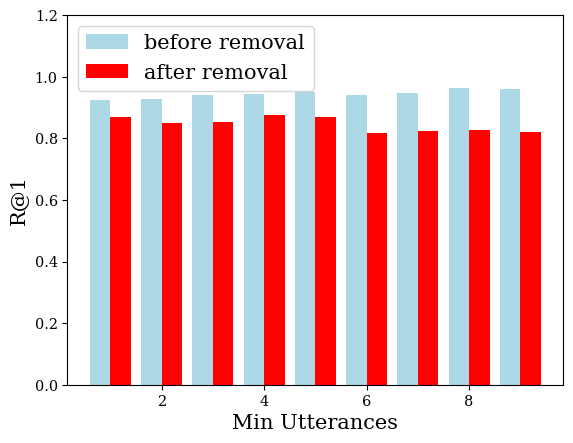

In [ ]:
w = 0.4
plt.rc('font', family='serif', size=15)
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.bar(X - w/2, Y1, color='lightblue', width=w, align='center', label="before removal")
plt.bar(X + w/2, Y2, color='red', width=w, align='center', label="after removal")
plt.xlabel("Min Utterances")
plt.ylabel("R@1")
plt.ylim((0, 1.2))
plt.legend()

# Paper experiments

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
preds = []
with open("/content/drive/MyDrive/MUTUAL/modelplus-123456/mutual_dev_result.json") as f:
    for s in f.read().split("]"):
        if len(s) == 0:
            continue
        s += "]"
        preds.append(json.loads(s))
len(preds)

886

In [ ]:
turn_result = collections.defaultdict(list)
for pred, example in zip(preds, dev_examples):
    article = re.split(r"(f : |m : |M: |F: )", example['article'])
    article_ = []
    for a in article:
        if len(a) == 0 or a[:2] in ["M:", "F:", "m:", "f:"]:
            continue
        article_.append(a)
    turns = len(article_)
    if turns <= 10:
        turns = str(turns)
    else:
        turns = ">10"
    turn_result[turns].append((pred, example))

In [ ]:

turn_acc = collections.defaultdict(float)
for turn in turn_result:
    total = 0.
    correct = 0.
    for pred, example in turn_result[turn]:
        m = np.argmax(pred)
        label = ANS.index(example['answers'])
        total += 1
        if label == m:
            correct += 1
    turn_acc[turn] = correct / total

In [ ]:
turn_acc

defaultdict(float,
            {'10': 0.9,
             '2': 1.0,
             '4': 0.9157088122605364,
             '6': 0.8650793650793651,
             '8': 0.9401197604790419,
             '>10': 0.9473684210526315})

In [ ]:
X = ['2', '4', '6', '8', '10', '>10']
Y = [turn_acc[x] for x in X]

In [ ]:
from matplotlib import rc

# Set the global font to be DejaVu Sans, size 10 (or any other sans-serif font of your choice!)
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':10})

# Set the font used for MathJax - more on this later
rc('mathtext',**{'default':'regular'})

Text(0, 0.5, 'R@1')

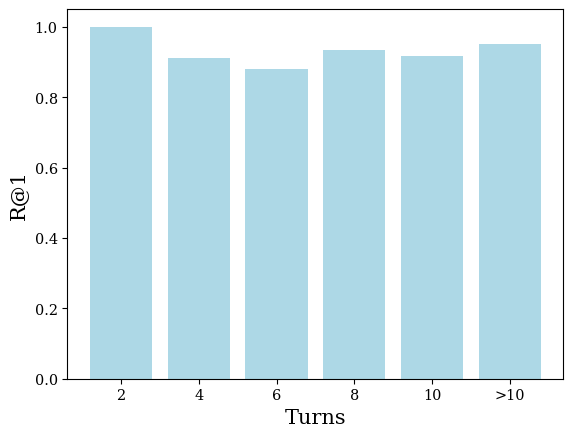

In [ ]:
plt.rc('font', family='serif', size=15)
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.bar(X, Y, color='lightblue')
plt.xlabel("Turns")
plt.ylabel("R@1")

886
0
R@1: 0.923 	 R@2: 0.981 	 MRR 0.958

880
1
R@1: 0.868 	 R@2: 0.960 	 MRR 0.927

619
2
R@1: 0.869 	 R@2: 0.957 	 MRR 0.927

493
3
R@1: 0.874 	 R@2: 0.964 	 MRR 0.930

326
4
R@1: 0.897 	 R@2: 0.977 	 MRR 0.945

266
5
R@1: 0.900 	 R@2: 0.972 	 MRR 0.945

198
6
R@1: 0.896 	 R@2: 0.973 	 MRR 0.943

154
7
R@1: 0.902 	 R@2: 0.976 	 MRR 0.946

105
8
R@1: 0.907 	 R@2: 0.976 	 MRR 0.949

73
9
R@1: 0.913 	 R@2: 0.973 	 MRR 0.952

# Option Similarity

In [ ]:
from transformers import ElectraTokenizer, ElectraModel

In [ ]:
tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')
model = ElectraModel.from_pretrained('google/electra-small-discriminator')
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
pass

In [ ]:
import torch
import numpy as np

In [ ]:
lm = model.electra

def get_sim(s1, s2):
    lm.eval()
    i1 = tokenizer(s1, return_tensors="pt")
    i2 = tokenizer(s2, return_tensors="pt")
    i1 = i1.to(device)
    i2 = i2.to(device)
    x1 = lm(**i1).last_hidden_state[0][0]
    x2 = lm(**i2).last_hidden_state[0][0]
    x1 = x1.unsqueeze(0)
    x2 = x2.unsqueeze(0)
    return torch.nn.functional.cosine_similarity(x1, x2).item()
get_sim("hello", "hello")

1.0

In [ ]:
def get_sim_matrix(options):
    x = np.zeros((4, 4))
    for i in range(4):
        for j in range(4):
            x[i, j] = get_sim(options[i], options[j])
    return x

In [ ]:
preds = load_pred("/content/drive/MyDrive/MUTUAL/modelplus-123456/mutual_dev_result.json")
preds[list(preds.keys())[0]]

[-9.314994812011719,
 -8.815186500549316,
 -16.09781265258789,
 -2.8014121055603027]

In [ ]:
T = {}
F = {}
d = {}
for example in dev_examples:
    x = get_sim_matrix(example['options'])
    x[x == 1] = 0
    id_ = example['id']
    pred = preds[f'dev-data/mutual/dev/{id_}.txt']
    if np.argmax(pred) == ANS.index(example['answers']):
        T[id_] = x
    else:
        F[id_] = x
    d[id_] = (x, np.argmax(pred) == ANS.index(example['answers']))
    print(x.max(), np.argmax(pred) == ANS.index(example['answers']))

0.9933403134346008 True
0.9730917811393738 True
0.982312023639679 False
0.9877215623855591 True
0.9797727465629578 True
0.9833609461784363 True
0.9770833849906921 True
0.9883682727813721 True
0.97932368516922 True
0.99531090259552 True
0.9855361580848694 True
0.9852820038795471 True
0.99909508228302 True
0.9887834191322327 True
0.9930760264396667 True
0.9784441590309143 True
0.9815089106559753 True
0.999821662902832 True
0.9731361865997314 True
0.9912751317024231 True
0.9863166213035583 True
0.9866626262664795 True
0.9895480871200562 True
0.9841193556785583 True
0.9989290237426758 True
0.9944519996643066 True
0.9753836393356323 True
0.9782003164291382 True
0.9941490292549133 True
0.9827420115470886 False
0.9762673377990723 True
0.9853280186653137 True
0.9844838380813599 True
0.9886013865470886 True
0.9830775856971741 False
0.9766391515731812 True
0.984000027179718 True
0.9866891503334045 True
0.9903868436813354 True
0.9926674365997314 True
0.9755593538284302 True
0.9808358550071716 Tru

In [ ]:
d

{'dev_329': (array([[0.89423925, 0.87968403, 0.8634755 , 0.90257478],
         [0.87518644, 0.89470369, 0.88634747, 0.8785789 ],
         [0.86466134, 0.88940865, 0.87742746, 0.90099889],
         [0.90312338, 0.87497205, 0.84750527, 0.91211307]]), True)}

In [ ]:
x1, x2 = [], []
y1, y2 = [], []
i = 0
for id_ in d:
    x, p = d[id_]
    if p:
        x1.append(i)
        y1.append(x.max())
    else:
        x2.append(i)
        y2.append(x.max())
    i += 1

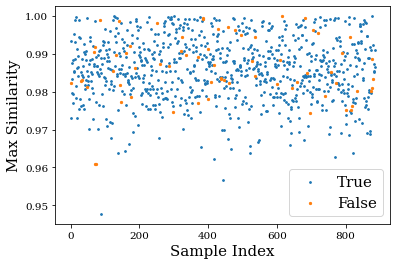

In [ ]:
plt.rc('font', family='serif', size=15)
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

plt.scatter(x1, y1, s=3, label="True")
plt.scatter(x2, y2, s=5, label="False")
plt.xlabel("Sample Index")
plt.ylabel("Max Similarity")
plt.legend()

In [ ]:
x1, x2 = [], []
y1, y2 = [], []
i = 0
for example in tqdm(dev_examples):
    # x = get_sim_matrix(example['options'])
    # x[x == 1] = 0
    id_ = example['id']
    pred = preds[f'dev-data/mutual/dev/{id_}.txt']
    if np.argmax(pred) == ANS.index(example['answers']):
        x1.append(i)
        y1.append(np.var(pred))
    else:
        x2.append(i)
        y2.append(np.var(pred))
    d[id_] = (x, np.argmax(pred) == ANS.index(example['answers']))
    i += 1



100%|██████████| 886/886 [00:00<00:00, 15057.35it/s]


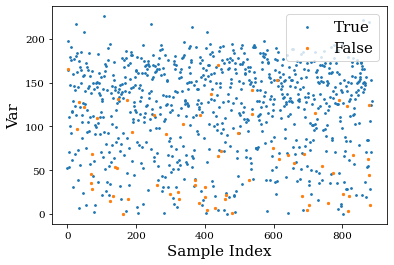

In [ ]:
plt.rc('font', family='serif', size=15)
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

plt.scatter(x1, y1, s=3, label="True")
plt.scatter(x2, y2, s=5, label="False")
plt.xlabel("Sample Index")
plt.ylabel("Var")
plt.legend()

In [ ]:
x1, x2 = [], []
y1, y2 = [], []
i = 0
for example in dev_examples:
    # x = get_sim_matrix(example['options'])
    # x[x == 1] = 0
    id_ = example['id']
    x, r = d[id_]
    pred = preds[f'dev-data/mutual/dev/{id_}.txt']
    label = ANS.index(example['answers'])
    sims = x[label][x[label] != 0]
    
    if r:
        x1.append(i)
        y1.append(np.min(sims))
    else:
        x2.append(i)
        y2.append(np.min(sims))
    i += 1

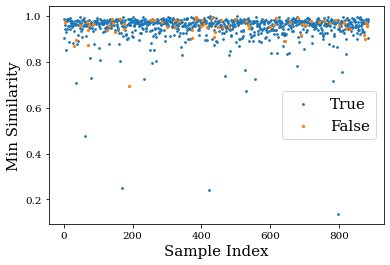

In [ ]:
plt.rc('font', family='serif', size=15)
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

plt.scatter(x1, y1, s=3, label="True")
plt.scatter(x2, y2, s=5, label="False")
plt.xlabel("Sample Index")
plt.ylabel("Min Similarity")
plt.legend()

In [ ]:
x1, x2 = [], []
y1, y2 = [], []
i = 0
for example in dev_examples:
    # x = get_sim_matrix(example['options'])
    # x[x == 1] = 0
    id_ = example['id']
    x, r = d[id_]
    pred = preds[f'dev-data/mutual/dev/{id_}.txt']
    label = ANS.index(example['answers'])
    sims = x[label][x[label] != 0]
    
    if r:
        x1.append(i)
        y1.append(np.mean(sims))
    else:
        x2.append(i)
        y2.append(np.mean(sims))
    i += 1

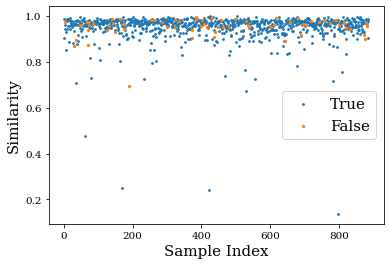

In [ ]:
plt.rc('font', family='serif', size=15)
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

plt.scatter(x1, y1, s=3, label="True")
plt.scatter(x2, y2, s=5, label="False")
plt.xlabel("Sample Index")
plt.ylabel("Similarity")
plt.legend()